In [1]:
!pip install sentence_transformers
!pip install torch_geometric
!pip install opentsne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd /content/drive/MyDrive/CS5284

[Errno 2] No such file or directory: '/content/drive/MyDrive/CS5284'
/scratch/users/nus/e1329380/cs5284/QA_graph/training-graph-models


In [1]:
import random
import numpy as np
from matplotlib import pyplot

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

# adjust this import accordingly to how you call the script
from functions import *
from torch.utils.data import DataLoader

# evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# visualise learnt intermediate embeddings
import matplotlib.pyplot as plt
from openTSNE import TSNE
# from sklearn.manifold import TSNE # very slow
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# visualise learnt output embeddings
def visualize(h, color):
    # z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    z = tsne.fit(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    print(f"Number of positive is {sum(color)}")
    print(f"Total number is {len(color)}")
    s = [0.5 if c==0 else 7 for c in color]

    plt.scatter(z[:, 0], z[:, 1], s=1, c=color, cmap=pyplot.jet())
    plt.show()

In [2]:
# train code
def train(dataloader):
    """
    one epoch
    returns average loss for one epoch
    """
    model.train()
    total_loss = 0

    # loop batches from dataloader
    for d, (batched_subgraphs, labels) in enumerate(dataloader):

        optimizer.zero_grad()

        batched_subgraphs = batched_subgraphs.to(device)
        labels = [label.to(device) for label in labels]

        # forward pass
        out, x_inter = model(batched_subgraphs)

        # calculate loss
        batch_loss = 0
        for i, label in enumerate(labels):
            node_mask = (batched_subgraphs.batch == i)
            logits = out[node_mask]
            target = label.float()

            pos_weight = torch.tensor([len(target) / target.sum()], device=device)
            loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            batch_loss += loss_fn(logits, target)

        # backward pass and optimization step
        batch_loss.backward()
        optimizer.step()

        # shift back to cpu
        batch_loss = batch_loss.detach().cpu()
        output_cpu = out.detach().cpu()
        x_inter_cpu = x_inter.detach().cpu()
        labels_cpu = [label.detach().cpu() for label in labels]

        total_loss += batch_loss.item()

        # print batch loss every 5 steps
        if d%5 == 0:
            print('Batch loss is', batch_loss.item())
        
        # visualise last batch in the epoch
        if d == len(dataloader) - 1:
            visualize(x_inter_cpu, color=torch.cat(labels_cpu, dim=0))
    
    torch.cuda.empty_cache() # help clear cache taking up cuda space

    return total_loss / len(dataloader)

# evaluation code
def evaluate(dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batched_subgraphs, labels in dataloader:
            batched_subgraphs = batched_subgraphs.to(device)
            labels = [label for label in labels]

            out, _ = model(batched_subgraphs)
            output_cpu = out.detach().cpu()

            # calculate accuracy for each subgraph
            for i, label in enumerate(labels):
                node_mask = (batched_subgraphs.batch == i).detach().cpu()
                preds = (torch.sigmoid(output_cpu[node_mask]) > 0.5).int()
                
                all_preds.extend(preds.tolist())
                all_labels.extend(label.tolist())
                correct += (preds == label).sum().item()
                total += label.size(0)

    precision = precision_score(all_labels, all_preds, average='binary') # for positive class
    recall = recall_score(all_labels, all_preds, average='binary') # for positive class
    f1 = f1_score(all_labels, all_preds, average='binary') # for positive class
    accuracy = correct / total # biased towards 0

    torch.cuda.empty_cache() # help clear cache taking up cuda space

    return accuracy, precision, recall, f1, all_preds, all_labels

In [3]:
# not sure
def focal_loss(logits, labels, alpha=0.25, gamma=2.0):
    """
    NOT USED.
    logits: Predicted output from the model (after log-softmax).
    labels: Ground truth labels (0 or 1).
    alpha: Balancing factor for the minority class.
    gamma: Focusing parameter for adjusting the rate at which easy examples are down-weighted.
    """
    # Compute cross-entropy loss per example
    ce_loss = F.nll_loss(logits, labels, reduction='none')
    # Probabilities for each example
    pt = torch.exp(-ce_loss)
    # Apply the focal loss adjustment
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss

    # Return the mean loss
    return focal_loss.mean()

In [4]:
# load data
path_to_node_embed = '../Datasets/MetaQA_dataset/processed/node2vec _embeddings/ud_node2vec_embeddings.txt'
path_to_idxes = '../Datasets/MetaQA_dataset/processed/idxes.json'
path_to_qa = '../Datasets/MetaQA_dataset/vanilla 3-hop/qa_train.txt'

# train
data = KGQADataset(path_to_node_embed, path_to_idxes, path_to_qa)
sub_data1 = torch.utils.data.Subset(data, list(range(3000)))
dataloader_train = DataLoader(sub_data1, batch_size=64, collate_fn=collate_fn, shuffle=True)
# some from train to evaluate
sub_data2 = torch.utils.data.Subset(data, list(range(5000, 5000+400)))
dataloader_val = DataLoader(sub_data2, batch_size=32, collate_fn=collate_fn, shuffle=True)

# some from test to evaluate
test = KGQADataset(path_to_node_embed, path_to_idxes, '../Datasets/MetaQA_dataset/vanilla 3-hop/qa_test.txt')
sub_data3 = torch.utils.data.Subset(test, list(range(400)))
dataloader_test = DataLoader(sub_data3, batch_size=32, collate_fn=collate_fn, shuffle=True)

### Test training GNN
1. Concatenate the question embedding with each node embedding.

In [5]:
torch.manual_seed(2024)
random.seed(2024)
np.random.seed(2024)

In [6]:
# model
class GCN(torch.nn.Module):
    def __init__(self, node_dim, question_dim, hidden_dim, output_dim=1):
        super(GCN, self).__init__()
        # 4 layers, 100 hidden_dim
        self.conv1 = GCNConv(node_dim + question_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, output_dim)

    def forward(self, batched_subgraphs):
        # concatenate question embeddings with node features for each subgraph along feature dimension
        question_emb_expanded = []
        for subgraph in batched_subgraphs.to_data_list():
            subgraph.x = torch.cat((subgraph.x, subgraph.qn.unsqueeze(0).expand(subgraph.x.size(0), -1)), dim=1)
            question_emb_expanded.append(subgraph.x)

        batched_subgraphs.x = torch.cat(question_emb_expanded, dim=0)
        x, edge_index = batched_subgraphs.x, batched_subgraphs.edge_index

        # GCN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x_inter = self.conv3(x, edge_index)
        x = F.relu(x_inter)
        x = self.conv4(x, edge_index)
        # Output logits directly for BCEWithLogitsLoss
        return x.squeeze(-1), x_inter

# Binary classification (answer candidate or not)
model = GCN(node_dim=64, question_dim=384, hidden_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
# train 2 epoch
for epoch in range(2):
    loss = train(dataloader_train)
    val_accuracy, val_p, val_r, val_f1, _, _ = evaluate(dataloader_val)
    test_accuracy, test_p, test_r, test_f1, _, _ = evaluate(dataloader_test)
    print(f'Epoch {epoch}, Train Loss: {loss}')
    print(f'Validation Accuracy: {val_accuracy:.8f}, Validation P/R/F1: {val_p:.3f}/{val_r:.3f}/{val_f1:.3f}')
    print(f'Test Accuracy: {test_accuracy:.8f}, Test P/R/F1: {test_p:.3f}/{test_r:.3f}/{test_f1:.3f}')

### Test training GAT
1. Concatenate the question embedding with each node embedding.

In [5]:
torch.manual_seed(2024)
random.seed(2024)
np.random.seed(2024)

In [6]:
# model
class QuestionAwareGAT(torch.nn.Module):
    def __init__(self, node_dim, question_dim, hidden_dim, output_dim=1):
        super(QuestionAwareGAT, self).__init__()
        # 4 layers, 100 hidden_dim
        self.conv1 = GATConv(node_dim + question_dim, hidden_dim, heads=1, concat=True)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1, concat=True)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1, concat=True)
        self.conv4 = GATConv(hidden_dim, output_dim, heads=1, concat=True)

    def forward(self, batched_subgraphs):
        # concatenate question embeddings with node features for each subgraph along feature dimension
        question_emb_expanded = []
        for subgraph in batched_subgraphs.to_data_list():
            subgraph.x = torch.cat((subgraph.x, subgraph.qn.unsqueeze(0).expand(subgraph.x.size(0), -1)), dim=1)
            question_emb_expanded.append(subgraph.x)

        batched_subgraphs.x = torch.cat(question_emb_expanded, dim=0)
        x, edge_index = batched_subgraphs.x, batched_subgraphs.edge_index

        # GAT
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x_inter = self.conv3(x, edge_index)
        x = F.relu(x_inter)
        x = self.conv4(x, edge_index)
        # Output logits directly for BCEWithLogitsLoss
        return x.squeeze(-1), x_inter

# Binary classification (answer candidate or not)
model = QuestionAwareGAT(node_dim=64, question_dim=384, hidden_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Batch loss is 88.4964828491211
Batch loss is 88.61736297607422
Batch loss is 88.65533447265625
Batch loss is 88.46456909179688
Batch loss is 86.93435668945312
Batch loss is 81.63995361328125
Batch loss is 75.000732421875
Batch loss is 74.4173812866211
Batch loss is 70.38760375976562
Batch loss is 65.51304626464844
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 61.52 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 5.07 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 1.25 seconds
===> Running optimization with exaggeration=12.00, lr=51919.08 for 250 iterations...
Iteration   50, KL divergence 7.6108, 50 iterations in 12.1855 sec
Iteration  100, KL diver

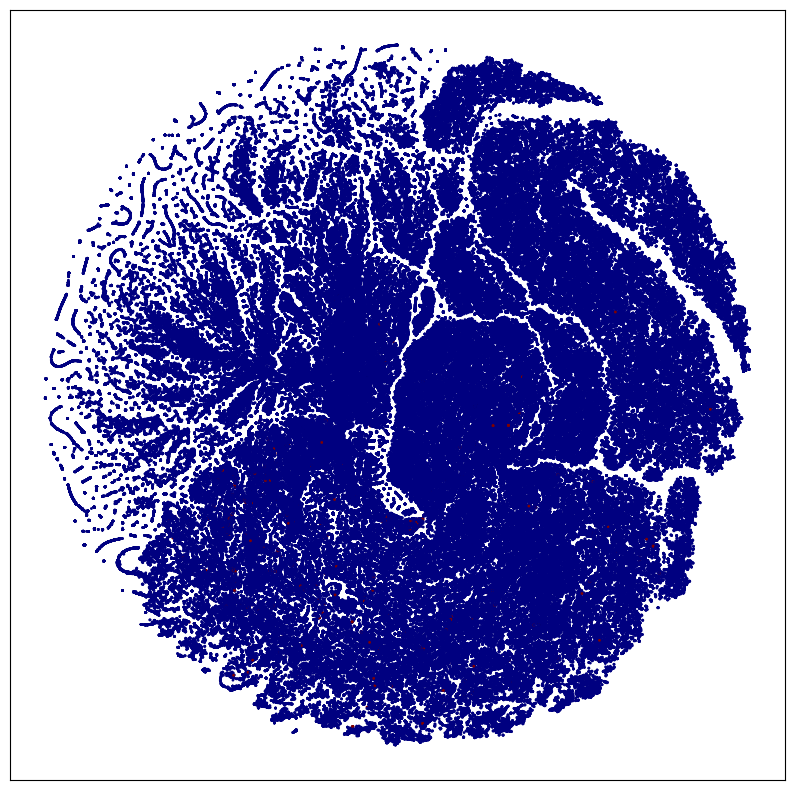

Epoch 0, Train Loss: 81.16340320668321
Validation Accuracy: 0.81536636, Validation P/R/F1: 0.004/0.542/0.007
Test Accuracy: 0.81073223, Test P/R/F1: 0.004/0.575/0.007
Batch loss is 71.2280502319336
Batch loss is 63.862300872802734
Batch loss is 65.5545883178711
Batch loss is 60.82901382446289
Batch loss is 61.95512008666992
Batch loss is 52.986778259277344
Batch loss is 62.52884292602539
Batch loss is 59.91522216796875
Batch loss is 58.934085845947266
Batch loss is 60.207515716552734
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 52.39 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 4.50 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 1.09 seconds
===

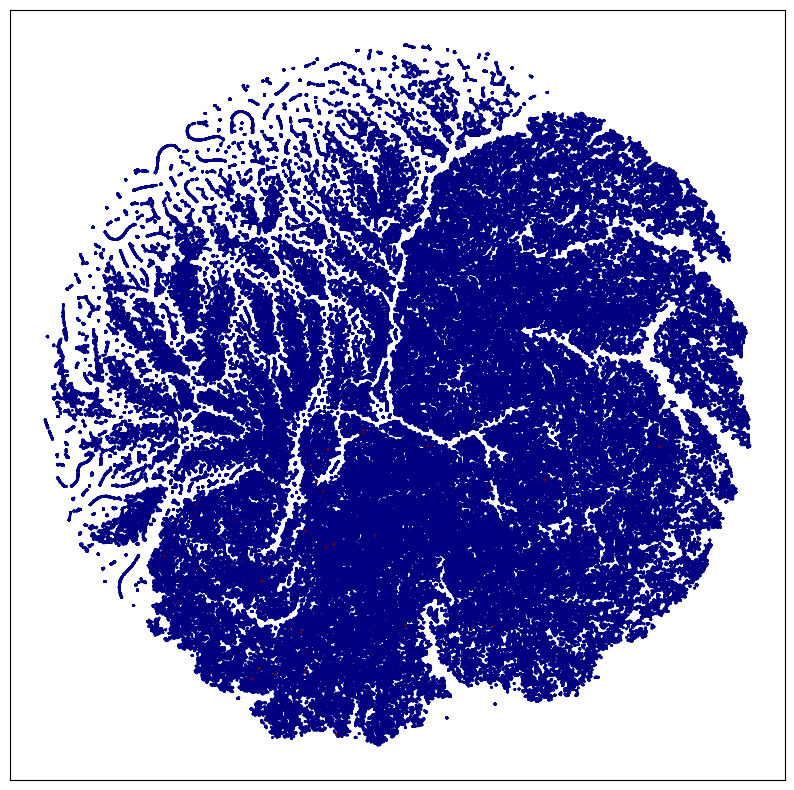

Epoch 1, Train Loss: 61.11830423233357
Validation Accuracy: 0.76405755, Validation P/R/F1: 0.004/0.728/0.007
Test Accuracy: 0.75308229, Test P/R/F1: 0.004/0.744/0.007


In [7]:
# train 2 epoch
for epoch in range(2):
    loss = train(dataloader_train)
    val_accuracy, val_p, val_r, val_f1, _, _ = evaluate(dataloader_val)
    test_accuracy, test_p, test_r, test_f1, _, _ = evaluate(dataloader_test)
    print(f'Epoch {epoch}, Train Loss: {loss}')
    print(f'Validation Accuracy: {val_accuracy:.8f}, Validation P/R/F1: {val_p:.3f}/{val_r:.3f}/{val_f1:.3f}')
    print(f'Test Accuracy: {test_accuracy:.8f}, Test P/R/F1: {test_p:.3f}/{test_r:.3f}/{test_f1:.3f}')